In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import ast

from plotnine import *
from scipy.fft import fft
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

import matplotlib.pyplot as mplt
import seaborn as sns
import matplotlib.colors as mcolors
import scipy.cluster.hierarchy as sch

from access_util import *

## Co-occupancy analysis

### Median Obv. - Exp. heatmap for each TF1 and TF2

In [2]:
rho_thres = 0.2
read_ct_thres = 100
motif_pair_ct_thres = 50
one_side_window_size = 1
proximity_range = [16, 100]
bound_filter_range = [0.01, 0.99]
adj_method = ['mean of footprint boundaries', 
              'mean of left peak + footprint + right peak boundaries',
              'median of footprint positions',
              'mean of footprint positions',
              'median of left peak + footprint + right peak positions',
              'mean of left peak + footprint + right peak positions']
adj_method_num = 3
exp_colname = 'expected_probability'
oe_colname = 'delta_oe_prob'
oe_colname_lite = 'delta_oe'

def ttest_pvalue(series):
    # Perform a one-sample t-test against zero
    t_stat, p_value = ttest_1samp(series, popmean=0)
    return p_value

for cell_type in ['HepG2', 'K562']:
    ### new cobidning data
    # motif stats file
    statsFile = f'/Users/tianyu/Downloads/TF_summary.features_filtered_{cell_type}_modeled.csv'
    df_motif_stats = pd.read_csv(statsFile)
    df_motif_stats['center_pos_list'] = df_motif_stats['center_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats['l_peak_pos_list'] = df_motif_stats['l_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats['r_peak_pos_list'] = df_motif_stats['r_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats = df_motif_stats.loc[(df_motif_stats['cell_type'] == cell_type) & (df_motif_stats['model_rho'] > rho_thres)].copy()

    cobind_statsDir = '/Users/tianyu/Downloads/ACCESS_proj/cobinding_v2_read_thres50_rho0/'
    stats_file_suffix = '.cobinding_stats.csv.gz'
    df_motif_list = pd.DataFrame([x.replace(stats_file_suffix, '').split('_', maxsplit=2) + [x] for x in os.listdir(f'{cobind_statsDir}/{cell_type}_footprint_mean') if stats_file_suffix in x], columns=['cell_type', 'TF_name', 'motif_str', 'file_name'])


    df_cobinding_bound_median_all = pd.DataFrame()

    for TF1_name in tqdm(df_motif_list['TF_name'].unique(), desc="Processing TFs"):
        # load new data
        row_cobind = df_motif_list.loc[df_motif_list['TF_name'] == TF1_name].iloc[0].copy()
        df_cobinding = pd.read_csv(f'{cobind_statsDir}/{cell_type}_footprint_mean/{row_cobind['file_name']}')
        df_cobinding_bound = df_cobinding.loc[
            (df_cobinding['read_type_pair'] == 'bound--bound') & 
            (df_cobinding['shared_read_ct'] >= read_ct_thres) &
            (df_cobinding['TF2'].isin(df_motif_list['TF_name']))
        ].copy()

        # calcualte obs-exp probability difference
        df_cobinding_bound['delta_oe_prob'] = df_cobinding_bound['observed_probability'] - df_cobinding_bound['expected_probability']

        # filtering out motif pairs with extremely low or high bound probability on either motifs
        df_cobinding_bound_filtered = df_cobinding_bound.loc[df_cobinding_bound[exp_colname].between(bound_filter_range[0], bound_filter_range[1], inclusive='both')].copy()

        # adjust center distance calculation
        df_cobinding_bound_filtered['center_dist'] = df_cobinding_bound_filtered.apply(lambda row: calc_center_distance_v2(row, df_motif_stats, adj_method_num=adj_method_num), axis=1)
        df_cobinding_bound_temp = df_cobinding_bound_filtered.loc[df_cobinding_bound_filtered['center_dist'].abs().between(proximity_range[0], proximity_range[1], inclusive='both')].copy()

        if len(df_cobinding_bound_temp) > 0:
            df_cobinding_bound_median = df_cobinding_bound_temp.groupby(['TF1', 'TF2']).agg(
                delta_oe_median=('delta_oe_prob', 'median'),
                delta_oe_ct=('delta_oe_prob', 'size'),
                delta_oe_pval=('delta_oe_prob', ttest_pvalue)
            ).reset_index()

            df_cobinding_bound_median_all = pd.concat([df_cobinding_bound_median_all, df_cobinding_bound_median], ignore_index=True)

    df_cobinding_bound_median_all = df_cobinding_bound_median_all.loc[df_cobinding_bound_median_all['delta_oe_ct'] >= motif_pair_ct_thres].copy()
    df_cobinding_bound_median_all['delta_oe_pval'] = df_cobinding_bound_median_all['delta_oe_pval'].fillna(1)
    df_cobinding_bound_median_all['delta_oe_pval_corrected'] = multipletests(df_cobinding_bound_median_all['delta_oe_pval'], method='bonferroni')[1]
    df_cobinding_bound_median_all.sort_values(['TF1', 'TF2'], ignore_index=True, inplace=True)
    df_cobinding_bound_median_all.to_csv(f'{cobind_statsDir}/cobinding_bound_median_all_{cell_type}_2.csv', index=False)


Processing TFs:  14%|█▍        | 9/63 [00:20<01:57,  2.17s/it]/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
Processing TFs:  27%|██▋       | 17/63 [00:38<01:43,  2.25s/it]/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: invalid value encountered in scalar multiply
Processing TFs:  40%|███▉      | 25/63 [01:09<02:12,  3.49s/it]/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1087: RuntimeWarning: divide by zero encountered in divide
/Users/tianyu/miniconda3/envs/access/lib/pytho

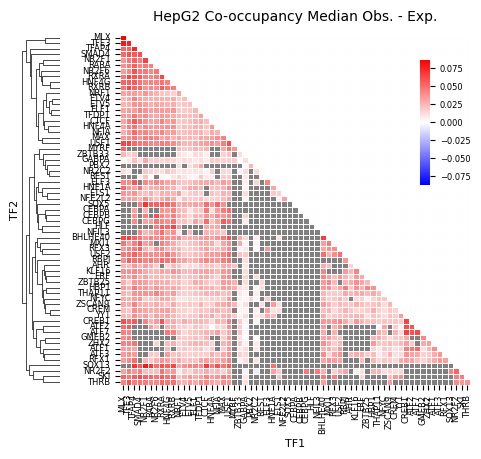

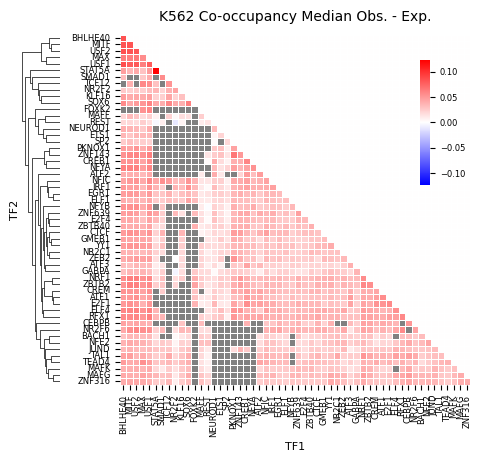

In [4]:
# Adjustable parameters
dendro_linewidth = 0.5  # Line width for dendrograms
tf_label_fontsize = 6   # Font size for TF names on axes
colorbar_fontsize = 6
axis_label_fontsize = 8
column_dendrogram = False  # Display column dendrogram
row_dendrogram = True  # Display row dendrogram
fig_size = (5, 5)

for cell_type in ['HepG2', 'K562']:
    cobind_statsDir = '/Users/tianyu/Downloads/ACCESS_proj/cobinding_v2_read_thres50_rho0/'
    df_cobinding_bound_median_all = pd.read_csv(f'{cobind_statsDir}/cobinding_bound_median_all_{cell_type}.csv')

    ## heatmap of observed_expected_delta_median
    mid_value = 0
    max_value = df_cobinding_bound_median_all['delta_oe_median'].abs().max()

    # Create a custom colormap with red-to-white and white-to-blue gradients
    colors = [
        (0, 0, 1),   # Blue
        (1, 1, 1),  # White (midpoint)
        (1, 0, 0)  # Red
    ]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("red_white_blue", colors, N=256)
    custom_cmap.set_bad(color='gray')  # Set gray color for NaN values
    norm = mcolors.TwoSlopeNorm(vmin=-max_value, vcenter=mid_value, vmax=max_value)

    heatmap_data = df_cobinding_bound_median_all.pivot_table(values='delta_oe_median', index='TF2', columns='TF1')
    
    # Save original NaN mask for later
    nan_mask = heatmap_data.isna()

    # Temporarily replace NaN values with 0 (or another neutral value) for clustering
    heatmap_data_clustering = heatmap_data.fillna(0)

    # Perform clustering
    clustergrid = sns.clustermap(
        heatmap_data_clustering, 
        cmap=custom_cmap, 
        norm=norm, linewidths=0.5, 
        figsize=fig_size, 
        col_cluster=True, row_cluster=True, 
        dendrogram_ratio=(0.1, 0.1), 
        cbar_pos=None, 
        yticklabels=True, xticklabels=True
    )
    mplt.close()

    # Retrieve dendrogram linkage matrices
    col_linkage = clustergrid.dendrogram_col.linkage
    row_linkage = clustergrid.dendrogram_row.linkage

    # Reverse the row linkage to flip the left dendrogram
    row_linkage[:, [0, 1]] = row_linkage[:, [1, 0]]  # Swap columns to flip orientation

    # Restore NaN values in the reordered data for visualization
    clustered_columns = clustergrid.data2d.columns
    clustered_rows = clustergrid.data2d.index
    heatmap_data = heatmap_data.loc[clustered_rows, clustered_columns]
    heatmap_data[nan_mask] = np.nan

    # Set all values in the upper-right triangle to zero
    upper_triangle_mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)
    heatmap_data.values[upper_triangle_mask] = 0

    # Plot the final heatmap with dendrograms
    fig = mplt.figure(figsize=fig_size)

    # Adjust axes positions to move the dendrograms
    if column_dendrogram and row_dendrogram:
        ax_main = fig.add_axes([0.2, 0.2, 0.6, 0.6])  # Main heatmap area with more space for labels
        ax_colorbar = fig.add_axes([0.82, 0.2, 0.02, 0.6])  # Adjusted color bar remains on the right
        ax_dendro_col = fig.add_axes([0.2, 0.05, 0.6, 0.1]) 
        ax_dendro_row = fig.add_axes([0.05, 0.2, 0.1, 0.6])
    elif column_dendrogram:
        ax_main = fig.add_axes([0.2, 0.2, 0.6, 0.6])   # Main heatmap area with more space for labels
        ax_colorbar = fig.add_axes([0.82, 0.2, 0.02, 0.6])  # Adjusted color bar remains on the right
        ax_dendro_col = fig.add_axes([0.2, 0.05, 0.6, 0.1]) 
    elif row_dendrogram:
        ax_main = fig.add_axes([0.25, 0.15, 0.7, 0.7])  # Main heatmap area with more space for labels
        ax_colorbar = fig.add_axes([0.85, 0.55, 0.02, 0.25])  # Adjusted color bar remains on the right
        ax_dendro_row = fig.add_axes([0.05, 0.15, 0.08, 0.7])
    else:
        ax_main = fig.add_axes([0.2, 0.2, 0.6, 0.6])  # Main heatmap area with more space for labels
        ax_colorbar = fig.add_axes([0.82, 0.2, 0.02, 0.6])  # Adjusted color bar remains on the right

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap=custom_cmap,
        norm=norm, linewidths=0.5,
        cbar=True, cbar_ax=ax_colorbar,
        ax=ax_main,
        xticklabels=True, yticklabels=True,
        square=True
    )

    # Update font size and add title
    ax_main.tick_params(axis='x', labelsize=tf_label_fontsize)
    ax_main.tick_params(axis='y', labelsize=tf_label_fontsize)
    ax_colorbar.tick_params(labelsize=colorbar_fontsize) # Update font size for colorbar tick labels
    ax_main.set_xlabel('TF1', fontsize=axis_label_fontsize)
    ax_main.set_ylabel('TF2', fontsize=axis_label_fontsize)
    ax_main.set_title(f"{cell_type} Co-occupancy Median Obs. - Exp.", fontsize=10, pad=10) # Add a title on top of the heatmap
    
    # Bottom dendrogram
    if column_dendrogram:
        ax_dendro_col.axis('off')
    
        # Plot dendrograms with reduced line width and flipped orientation
        sch.dendrogram(col_linkage, ax=ax_dendro_col, orientation='bottom', color_threshold=0, above_threshold_color='black')
        for line in ax_dendro_col.collections:
            line.set_linewidth(dendro_linewidth)

        ax_main.set_xlabel('') # Remove axis labels for the heatmap
        fig.text(0.5, 0.04, "TF1", fontsize=axis_label_fontsize, rotation=0, va='center', ha='center') # Add the title for the bottom dendrogram (TF1) below it

    # Left dendrogram
    if row_dendrogram:
        ax_dendro_row.axis('off')

        sch.dendrogram(row_linkage, ax=ax_dendro_row, orientation='left', color_threshold=0, above_threshold_color='black')
        for line in ax_dendro_row.collections:
            line.set_linewidth(dendro_linewidth)

        ax_main.set_ylabel('') # Remove axis labels for the heatmap
        fig.text(0.04, 0.5, "TF2", fontsize=axis_label_fontsize, rotation=90, va='center', ha='center') # Add the title for the left dendrogram (TF2) to its left

    # Save the final plot
    fig.savefig(f'{cobind_statsDir}/plots/cobinding_bound_delta_oe_median_{cell_type}.pdf')
    mplt.show()

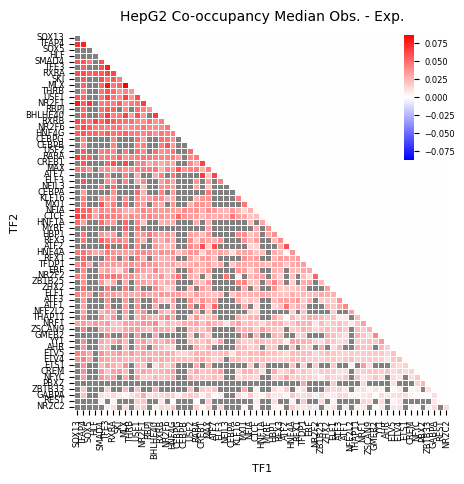

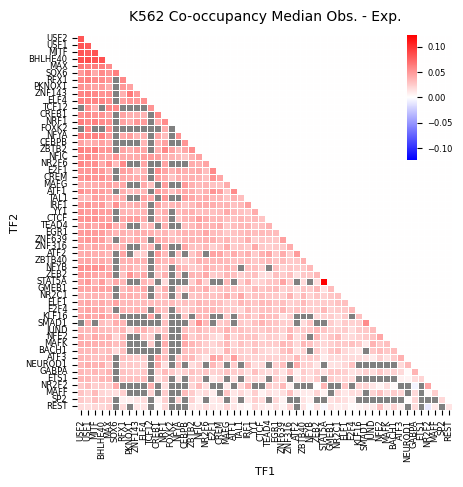

In [31]:
# Adjustable parameters
tf_label_fontsize = 6   # Font size for TF names on axes
colorbar_fontsize = 6
axis_label_fontsize = 8
fig_size = (5, 5)

for cell_type in ['HepG2', 'K562']:
    cobind_statsDir = '/Users/tianyu/Downloads/ACCESS_proj/cobinding_v2_read_thres50_rho0/'
    df_cobinding_bound_median_all = pd.read_csv(f'{cobind_statsDir}/cobinding_bound_median_all_{cell_type}.csv')

    ## heatmap of observed_expected_delta_median
    mid_value = 0
    max_value = df_cobinding_bound_median_all['delta_oe_median'].abs().max()

    # Create a custom colormap with red-to-white and white-to-blue gradients
    colors = [
        (0, 0, 1),   # Blue
        (1, 1, 1),  # White (midpoint)
        (1, 0, 0)  # Red
    ]
    custom_cmap = mcolors.LinearSegmentedColormap.from_list("red_white_blue", colors, N=256)
    custom_cmap.set_bad(color='gray')  # Set gray color for NaN values
    norm = mcolors.TwoSlopeNorm(vmin=-max_value, vcenter=mid_value, vmax=max_value)

    heatmap_data = df_cobinding_bound_median_all.pivot_table(values='delta_oe_median', index='TF2', columns='TF1')

    # order TF1 and TF2 by the mean of median_delta_oe
    # Reorder rows and columns in the heatmap data according to TF_ordered_list
    df_TF_order = df_cobinding_bound_median_all.groupby('TF1').agg(delta_oe_median_mean=('delta_oe_median', 'mean')).sort_values('delta_oe_median_mean', ascending=False).reset_index()
    TF_ordered_list = df_TF_order['TF1'].tolist()
    heatmap_data = heatmap_data.reindex(index=TF_ordered_list, columns=TF_ordered_list)

    # Set all values in the upper-right triangle to zero
    upper_triangle_mask = np.triu(np.ones_like(heatmap_data, dtype=bool), k=1)
    heatmap_data.values[upper_triangle_mask] = 0

    # Plot the final heatmap with dendrograms
    fig = mplt.figure(figsize=fig_size)

    # Adjust axes positions to move the dendrograms

    # elif row_dendrogram:
    #     ax_main = fig.add_axes([0.25, 0.15, 0.7, 0.7])  # Main heatmap area with more space for labels
    #     ax_colorbar = fig.add_axes([0.85, 0.55, 0.02, 0.25])  # Adjusted color bar remains on the right
    #     ax_dendro_row = fig.add_axes([0.05, 0.15, 0.08, 0.7])
    
    ax_main = fig.add_axes([0.15, 0.15, 0.75, 0.75])  # Main heatmap area with more space for labels
    ax_colorbar = fig.add_axes([0.81, 0.65, 0.02, 0.25])  # Adjusted color bar remains on the right

    # Plot heatmap
    sns.heatmap(
        heatmap_data,
        cmap=custom_cmap,
        norm=norm, linewidths=0.5,
        cbar=True, cbar_ax=ax_colorbar,
        ax=ax_main,
        xticklabels=True, yticklabels=True,
        square=True
    )

    # Update font size and add title
    ax_main.tick_params(axis='x', labelsize=tf_label_fontsize)
    ax_main.tick_params(axis='y', labelsize=tf_label_fontsize)
    ax_colorbar.tick_params(labelsize=colorbar_fontsize) # Update font size for colorbar tick labels
    ax_main.set_xlabel('TF1', fontsize=axis_label_fontsize)
    ax_main.set_ylabel('TF2', fontsize=axis_label_fontsize)
    ax_main.set_title(f"{cell_type} Co-occupancy Median Obs. - Exp.", fontsize=10, pad=10) # Add a title on top of the heatmap

    # Save the final plot
    fig.savefig(f'{cobind_statsDir}/plots/cobinding_bound_delta_oe_median_{cell_type}_2.pdf')
    mplt.show()

### Periodicity strength and correct p-value for TF1-all

In [20]:
cobind_statsDir = '/Users/tianyu/Downloads/cobinding_v2_read_thres50_rho0/'
period_range = [8, 13]

# df_fft_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster/TF1-all.fft.csv.gz')
df_fft_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster_footprint_mean/TF1-all.fft.csv.gz')
df_fft_filtered_all = df_fft_all.loc[
    (df_fft_all['bound_filter'] == '[0.01, 0.99]') &
    (df_fft_all['motif_pair_orientation'] == 'either strand')
].copy()

df_fft_stats_all = pd.DataFrame()
for (cell_type, TF_name), df_fft in df_fft_filtered_all.groupby(['cell_type', 'TF_name']):
    df_fft_stats = get_dominant_period(df_fft, min_period=period_range[0], max_period=period_range[1], alpha=1)
    df_fft_stats['pval_bh'] = multipletests(df_fft_stats['pval'], method='fdr_bh')[1]
    df_fft_stats['pval_bonferroni'] = multipletests(df_fft_stats['pval'], method='bonferroni')[1]

    df_fft_stats['cell_type'] = cell_type
    df_fft_stats['TF_name'] = TF_name
    df_fft_stats_all = pd.concat([df_fft_stats_all, df_fft_stats], ignore_index=True)

# df_fft_stats_all.to_csv(f'{cobind_statsDir}/final_test_cluster/TF1-all.fft_stats_all.csv', index=False)
df_fft_stats_all.to_csv(f'{cobind_statsDir}/final_test_cluster_footprint_mean/TF1-all.fft_stats_all.csv', index=False)
df_fft_stats_all

,side,dom_freq,dom_amp,signal_noise_ratio,pval,period,pval_bh,pval_bonferroni,cell_type,TF_name
0,Positive,0.117679,0.015705,0.588199,0.3585,8.497674,0.5025,0.717,HepG2,AHR
1,Negative,0.081395,0.013856,0.480065,0.5025,12.285714,0.5025,1.000,HepG2,AHR
2,Positive,0.079545,0.041598,1.494313,0.0015,12.571429,0.0015,0.003,HepG2,ATF1
3,Negative,0.122222,0.036748,1.509162,0.0010,8.181818,0.0015,0.002,HepG2,ATF1
4,Positive,0.111111,0.027785,0.995208,0.0515,9.000000,0.0515,0.103,HepG2,ATF2
...,...,...,...,...,...,...,...,...,...,...
227,Negative,0.125000,0.019539,0.773031,0.1760,8.000000,0.1760,0.352,K562,ZNF143
228,Positive,0.090909,0.018257,0.915596,0.0855,11.000000,0.0855,0.171,K562,ZNF316
229,Negative,0.079545,0.032963,1.536397,0.0010,12.571429,0.0020,0.002,K562,ZNF316
230,Positive,0.102273,0.012788,1.268758,0.0115,9.777778,0.0115,0.023,K562,ZNF639


/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


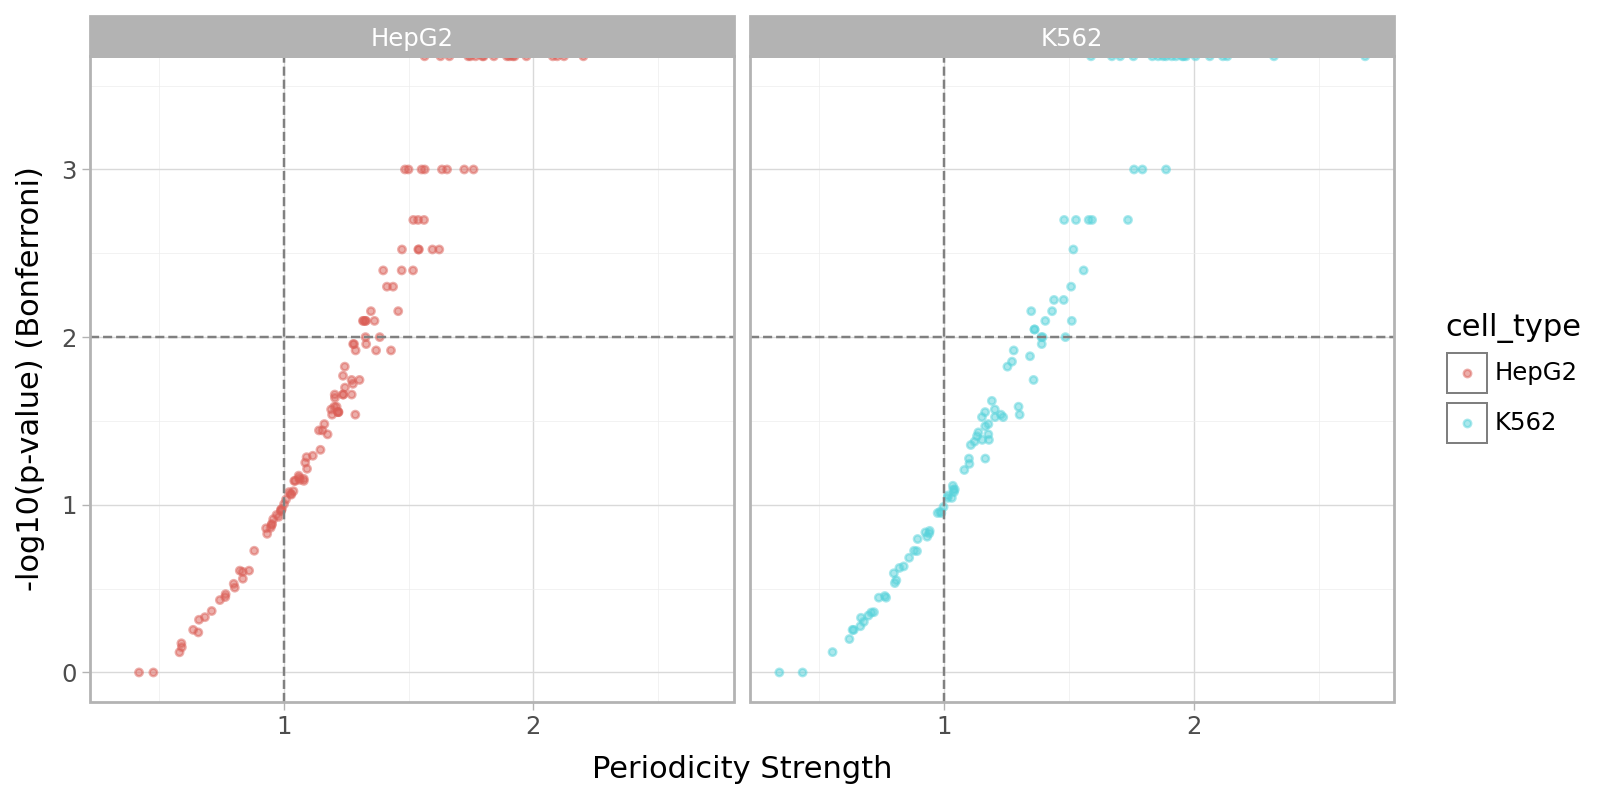

/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 8 x 4 in image.
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: /Users/tianyu/Downloads/cobinding_v2_read_thres50_rho0//plots/fft_volcano.pdf


In [59]:
# volcano plot
df_fft_stats_all = pd.read_csv(f'{cobind_statsDir}/cobind_data_new/TF1-all.fft_stats_all.csv')
df_fft_stats_all['-log10_pval_bonferroni'] = -np.log10(df_fft_stats_all['pval_bonferroni'])
df_fft_stats_all['-log10_pval_bh'] = -np.log10(df_fft_stats_all['pval_bh'])
df_fft_stats_all['signal_nosie_LFC'] = np.log2(df_fft_stats_all['signal_noise_ratio'])

plt = (
    ggplot(df_fft_stats_all, aes(x='signal_noise_ratio', y='-log10_pval_bonferroni', color='cell_type')) +
    geom_point(size=1, alpha=0.5) + ylim(0, 3.5) + 
    geom_hline(yintercept=-np.log10(0.01), linetype='dashed', color='gray') +
    geom_vline(xintercept=1, linetype='dashed', color='gray') +
    labs(x='Periodicity Strength', y='-log10(p-value) (Bonferroni)') +
    facet_wrap('~cell_type', ncol=2) +
    theme_light() + theme(figure_size=(8, 4))
)
plt.show()
plt.save(f'{cobind_statsDir}/plots/fft_volcano.pdf')

### TF1-all spacially-resolved co-occupancy plots in several formats

In [23]:
cobind_statsDir = '/Users/tianyu/Downloads/cobinding_v2_read_thres50_rho0/'
period_range = [8, 13]

# df_fft_stats_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster/TF1-all.fft_stats_all.csv')
# df_cobinding_bound_by_pos_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster/TF1-all.cobinding_bound_by_pos.csv.gz')
# df_cobinding_bound_ma_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster/TF1-all.cobinding_bound_ma.csv.gz')

df_fft_stats_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster_footprint_mean/TF1-all.fft_stats_all.csv')
df_cobinding_bound_by_pos_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster_footprint_mean/TF1-all.cobinding_bound_by_pos.csv.gz')
df_cobinding_bound_ma_all = pd.read_csv(f'{cobind_statsDir}/final_test_cluster_footprint_mean/TF1-all.cobinding_bound_ma.csv.gz')

df_selected_TFs = pd.read_csv(f'{cobind_statsDir}/selected_TF_list.csv')
selected_TFs_only = False

In [26]:
rho_thres = 0.2
read_ct_thres = 100
motif_pair_ct_thres = 50
one_side_window_size = 1
proximity_range = [16, 100]
bound_filter_range = [0.01, 0.99]
adj_method = ['mean of footprint boundaries', 
              'mean of left peak + footprint + right peak boundaries',
              'median of footprint positions',
              'mean of footprint positions',
              'median of left peak + footprint + right peak positions',
              'mean of left peak + footprint + right peak positions']
adj_method_num = 3
exp_colname = 'expected_probability'
oe_colname = 'delta_oe_prob'
oe_colname_lite = 'delta_oe'
stats_file_suffix = '.cobinding_stats.csv.gz'

for cell_type in ['HepG2', 'K562']:
    # cobinding stats file
    df_motif_list = pd.DataFrame([x.replace(stats_file_suffix, '').split('_', maxsplit=2) + [x] for x in os.listdir(f'{cobind_statsDir}/{cell_type}_footprint_mean') if stats_file_suffix in x], columns=['cell_type', 'TF_name', 'motif_str', 'file_name'])
    # df_motif_list = pd.DataFrame([x.replace(stats_file_suffix, '').split('_', maxsplit=2) + [x] for x in os.listdir(f'{cobind_statsDir}/{cell_type}') if stats_file_suffix in x], columns=['cell_type', 'TF_name', 'motif_str', 'file_name'])
    
    # motif stats file
    statsFile = f'/Users/tianyu/Downloads/TF_summary.features_filtered_{cell_type}_modeled.csv'
    df_motif_stats = pd.read_csv(statsFile)
    df_motif_stats['center_pos_list'] = df_motif_stats['center_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats['l_peak_pos_list'] = df_motif_stats['l_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats['r_peak_pos_list'] = df_motif_stats['r_peak_pos_list'].apply(lambda x: ast.literal_eval(x))
    df_motif_stats = df_motif_stats.loc[(df_motif_stats['cell_type'] == cell_type) & (df_motif_stats['model_rho'] > rho_thres)].copy()

    df_fft_stats_cell = df_fft_stats_all.loc[df_fft_stats_all['cell_type'] == cell_type].copy()
    df_fft_stats_max_cell = df_fft_stats_cell.loc[df_fft_stats_cell.groupby(['cell_type', 'TF_name'])['signal_noise_ratio'].idxmax()].reset_index(drop=True)
    df_fft_stats_max_cell.sort_values(['cell_type', 'signal_noise_ratio'], ascending=[True, False], inplace=True, ignore_index=True)

    if selected_TFs_only:
        df_selected_TFs_cell = df_selected_TFs.loc[df_selected_TFs['cell_type'] == cell_type].copy()
        df_fft_stats_max_cell = df_fft_stats_max_cell.loc[df_fft_stats_max_cell['TF_name'].isin(df_selected_TFs_cell['TF_name'])].copy()
        os.makedirs(f'{cobind_statsDir}/plots/final_selected_TFs_2/', exist_ok=True)
    else:
        os.makedirs(f'{cobind_statsDir}/plots/final_2/{cell_type}/', exist_ok=True)

    for index, row in tqdm(df_fft_stats_max_cell.iterrows(), desc=f"{cell_type} TFs", total=len(df_fft_stats_max_cell)):
        TF1_name = row['TF_name']

        # load new data
        row_cobind = df_motif_list.loc[df_motif_list['TF_name'] == TF1_name].iloc[0].copy()
        df_cobinding = pd.read_csv(f'{cobind_statsDir}/{cell_type}_footprint_mean/{row_cobind['file_name']}')
        # df_cobinding = pd.read_csv(f'{cobind_statsDir}/{cell_type}/{row_cobind['file_name']}')
        df_cobinding_bound = df_cobinding.loc[
            (df_cobinding['read_type_pair'] == 'bound--bound') & 
            (df_cobinding['shared_read_ct'] >= read_ct_thres) &
            (df_cobinding['TF2'].isin(df_motif_list['TF_name']))
        ].copy()

        # calcualte obs-exp probability difference
        df_cobinding_bound['delta_oe_prob'] = df_cobinding_bound['observed_probability'] - df_cobinding_bound['expected_probability']

        # filtering out motif pairs with extremely low or high bound probability on either motifs
        df_cobinding_bound_filtered = df_cobinding_bound.loc[df_cobinding_bound[exp_colname].between(bound_filter_range[0], bound_filter_range[1], inclusive='both')].copy()

        # adjust center distance calculation
        df_cobinding_bound_filtered['center_dist'] = df_cobinding_bound_filtered.apply(lambda row: calc_center_distance_v2(row, df_motif_stats, adj_method_num=adj_method_num), axis=1)
        df_cobinding_bound_TF = df_cobinding_bound_filtered.loc[df_cobinding_bound_filtered['center_dist'].abs().between(proximity_range[0], proximity_range[1], inclusive='both')].copy()

        if len(df_cobinding_bound_TF) > 0:
            # normalize observed - expected values
            filtered_values = df_cobinding_bound_TF[oe_colname].replace([np.inf, -np.inf], np.nan).dropna()
            oe_perc05 = np.percentile(filtered_values, 5)
            oe_perc95 = np.percentile(filtered_values, 95)
            df_cobinding_bound_stats_TF = pd.DataFrame({'oe_perc05': oe_perc05, 'oe_perc95': oe_perc95}, index=[0])
            df_cobinding_bound_TF[oe_colname + '_norm'] = df_cobinding_bound_TF[oe_colname].apply(lambda x: (x - oe_perc05)/(oe_perc95 - oe_perc05))         

            # # positional co-bidning plot (raw data, normalization guidelines)
            # plt = (
            #     ggplot() + 
            #     geom_point(df_cobinding_bound_TF, aes(x='center_dist', y=oe_colname), color='black', size=0.2, alpha=0.1) +
            #     geom_hline(df_cobinding_bound_stats_TF, aes(yintercept='oe_perc05'), color='red', linetype='dashed') +
            #     geom_hline(df_cobinding_bound_stats_TF, aes(yintercept='oe_perc95'), color='red', linetype='dashed') +
            #     labs(x='Displacement of adjacent motif', y='Obs. - Exp.') + 
            #     ggtitle(f'{TF1_name} - all') + 
            #     theme_light() + 
            #     theme(figure_size=(8,3), plot_title=element_text(size=12, ha='left'), 
            #         legend_position='bottom', legend_text_position='right',
            #         panel_grid_major_x=element_blank(), panel_grid_minor_x=element_blank())
            # )
            # # plt.show()
            # plt.save(f'{cobind_statsDir}/plots/final/{cell_type}/rank{index+1:02}_{TF1_name}.cobinding_style1.pdf')

            df_cobinding_bound_by_pos_TF = df_cobinding_bound_by_pos_all.loc[
                (df_cobinding_bound_by_pos_all['cell_type'] == cell_type) &
                (df_cobinding_bound_by_pos_all['TF_name'] == TF1_name) &
                (df_cobinding_bound_by_pos_all['bound_filter'] == str(bound_filter_range)) &
                (df_cobinding_bound_by_pos_all['motif_pair_orientation'] == 'either strand')
            ].copy()

            # df_cobinding_bound_ma_TF = agg_by_bin_window(df_cobinding_bound_TF, bin_col=oe_colname + '_norm', max_center_dist=proximity_range[1], one_side_window_size=one_side_window_size)
            # df_cobinding_bound_ma_TF = df_cobinding_bound_ma_TF.loc[df_cobinding_bound_ma_TF['center_dist'].abs() >= proximity_range[0]].copy()
            # df_cobinding_bound_ma_TF.rename(columns={oe_colname + '_norm' + '_by_pos': oe_colname_lite + '_by_pos' + '_norm'}, inplace=True)

            df_cobinding_bound_ma_TF = df_cobinding_bound_ma_all.loc[
                (df_cobinding_bound_ma_all['cell_type'] == cell_type) &
                (df_cobinding_bound_ma_all['TF_name'] == TF1_name) &
                (df_cobinding_bound_ma_all['bound_filter'] == str(bound_filter_range)) &
                (df_cobinding_bound_ma_all['motif_pair_orientation'] == 'either strand')
            ].copy()

            # # positional co-bidning plot (normalized raw data, positional median)
            # plt = (
            #     ggplot() + 
            #     geom_point(df_cobinding_bound_TF, aes(x='center_dist', y=oe_colname + '_norm'), color='black', size=0.2, alpha=0.1) +
            #     geom_point(df_cobinding_bound_by_pos_TF, aes(x='center_dist', y=oe_colname_lite + '_by_pos_norm'), color='blue', size=0.2, alpha=1) +
            #     labs(x='Displacement of adjacent motif', y='Normalized Obs. - Exp.') + 
            #     ggtitle(f'{TF1_name} - all') + 
            #     theme_light() + 
            #     theme(figure_size=(8,3), plot_title=element_text(size=12, ha='left'), 
            #         legend_position='bottom', legend_text_position='right',
            #         panel_grid_major_x=element_blank(), panel_grid_minor_x=element_blank())
            # )
            # # plt.show()
            # plt.save(f'{cobind_statsDir}/plots/final/{cell_type}/rank{index+1:02}_{TF1_name}.cobinding_style2.pdf')


            # # positional co-bidning dotmap
            # TF2_list = df_cobinding_bound_TF['TF2'].unique()
            # df_cobinding_bound_TF['y_pos'] = df_cobinding_bound_TF['TF2'].apply(lambda x: np.where(TF2_list == x)[0][0])
            # df_cobinding_bound_TF['delta_oe_prob_norm2'] = df_cobinding_bound_TF['delta_oe_prob_norm'].apply(lambda x: 1 if x>1 else 0 if x<0 else x)
            # df_cobinding_bound_TF['center_dist_rounded'] = df_cobinding_bound_TF['center_dist'].apply(lambda x: round(x))
            # plt = (
            #     ggplot(df_cobinding_bound_TF, aes(x='center_dist_rounded', y='y_pos', fill='delta_oe_prob_norm2')) + 
            #     geom_point(size=1, alpha=0.4, stroke=0) + 
            #     scale_fill_gradient2(low='white', high='red', mid='white', midpoint=0.5, name='Normalized Obs. - Exp.') + 
            #     labs(x='Displacement of adjacent motif', y='Motif pairs') +
            #     ggtitle(f'{TF1_name} - all') + theme_light() + 
            #     theme(figure_size=(8, 3.5), legend_position='bottom', axis_ticks_major_y=None, axis_text_y=None)
            # )
            # # plt.show()
            # plt.save(f'{cobind_statsDir}/plots/final/{cell_type}/rank{index+1:02}_{TF1_name}.cobinding_style3.pdf')

            df_fft_stats_TF = df_fft_stats_all.loc[
                (df_fft_stats_all['cell_type'] == cell_type) &
                (df_fft_stats_all['TF_name'] == TF1_name)
            ].copy()
            df_fft_stats_TF, df_trough_pos = get_period_shift(df_fft_stats_TF, df_cobinding_bound_by_pos_TF, y_column=oe_colname_lite + '_by_pos_norm')
            df_fft_stats_TF['side'] = pd.Categorical(df_fft_stats_TF['side'], categories=['Positive', 'Negative'])
            
            # # FFT frequency-amplitude plot
            # plt = (
            #     ggplot() + 
            #     geom_line(df_fft_TF, aes(x='frequency', y='amplitude', color='side')) + 
            #     geom_line(df_fft_TF, aes(x='frequency', y='CI_thres', color='side'), linetype='dashed') + 
            #     geom_rect(df_fft_stats_TF, xmin=1/max(period_range), xmax=1/min(period_range), ymin=-np.inf, ymax=np.inf, fill='red', alpha=0.1) +
            #     geom_vline(df_fft_stats_TF, aes(xintercept='dom_freq', color='side'), linetype='dashed') +
            #     geom_vline(xintercept=1/11, color='blue', linetype='dashed') + 
            #     # xlim(0, 0.5) + 
            #     coord_cartesian(ylim=(0, 0.1)) + 
            #     facet_grid('motif_pair_orientation ~ side') +
            #     labs(title='Fourier Transform - Frequency Spectrum', x='Frequency', y='Amplitude') + 
            #     theme_light() + theme(figure_size=(8,3), plot_title=element_text(size=12, ha='left'),
            #                         legend_position='bottom', legend_text_position='right')
            # )
            # plt.show()

            # # FFT frequency-signal/noise plot
            # plt = (
            #     ggplot() + 
            #     geom_line(df_fft_TF, aes(x='frequency', y='signal_noise_ratio', color='side')) + 
            #     geom_rect(df_fft_stats_TF, xmin=1/max(period_range), xmax=1/min(period_range), ymin=-np.inf, ymax=np.inf, fill='red', alpha=0.1) +
            #     geom_vline(df_fft_stats_TF, aes(xintercept='dom_freq', color='side'), linetype='dashed') +
            #     geom_vline(xintercept=1/11, color='blue', linetype='dashed') + geom_hline(yintercept=1, color='blue', linetype='dashed') + 
            #     xlim(0, 0.5) + 
            #     facet_grid('motif_pair_orientation ~ side') +
            #     labs(title='Fourier Transform - Frequency Spectrum', x='Frequency', y='Signal/Noise ratio') + 
            #     theme_light() + theme(figure_size=(8,3), plot_title=element_text(size=12, ha='left'),
            #                         legend_position='bottom', legend_text_position='right')
            # )
            # plt.show()

            # positional co-bidning plot (final)
            plt = (
                ggplot() + 
                geom_point(df_cobinding_bound_by_pos_TF, aes(x='center_dist', y=oe_colname_lite + '_by_pos_norm'), color='blue', size=0.2, alpha=0.5) +
                # geom_line(df_cobinding_bound_ma_TF, aes(x='center_dist', y=oe_colname_lite + '_by_pos_norm'), color='purple', size=0.5) +
                stat_smooth(df_cobinding_bound_by_pos_TF, aes(x='center_dist', y=oe_colname_lite + '_by_pos_norm'), color='purple', method='mavg', method_args={'window': 3, 'center': True}, size=0.5, se=False) +
                labs(x='Displacement of adjacent motif', y='Norm. Median (Obs. - Exp.)') + 
                ggtitle(f'{TF1_name} - all') + 
                theme_light() + 
                theme(figure_size=(8,3), plot_title=element_text(size=12, ha='left'), 
                    # legend_position='bottom', legend_text_position='right',
                    legend_position='none',
                    panel_grid_major_x=element_blank(), panel_grid_minor_x=element_blank())
            )
            y_min = df_cobinding_bound_by_pos_TF[oe_colname_lite + '_by_pos_norm'].min()
            y_max = df_cobinding_bound_by_pos_TF[oe_colname_lite + '_by_pos_norm'].max()
            y_diff = y_max - y_min
            df_fft_stats_pos = df_fft_stats_TF.loc[df_fft_stats_TF['side'] == 'Positive'].copy()
            df_fft_stats_pos['foot_str'] = df_fft_stats_pos.apply(lambda row: f"Dominant T: {row['period']:.2f}, Phase: +{row['period_shift']:.2f}", axis=1)
            df_fft_stats_pos['head_str'] = df_fft_stats_pos.apply(lambda row: f"Strength: {row['signal_noise_ratio']:.3f}, Corrected P-value: {row['pval_bonferroni']:.2f}", axis=1)
            df_fft_stats_neg = df_fft_stats_TF.loc[df_fft_stats_TF['side'] == 'Negative'].copy()
            df_fft_stats_neg['foot_str'] = df_fft_stats_neg.apply(lambda row: f'Dominant T: {row['period']:.2f}, Phase: +{row['period_shift']:.2f}', axis=1)
            df_fft_stats_neg['head_str'] = df_fft_stats_neg.apply(lambda row: f"Strength: {row['signal_noise_ratio']:.3f}, Corrected P-value: {row['pval_bonferroni']:.2f}", axis=1)
            plt += geom_vline(df_trough_pos, aes(xintercept='center_dist', color='side'), linetype='dashed', size=0.25)
            plt += geom_label(df_fft_stats_neg, aes(label='foot_str', color='side'), x=-proximity_range[1], y=y_min+y_diff*0.01, size=10, ha='left')
            plt += geom_label(df_fft_stats_neg, aes(label='head_str', color='side'), x=-proximity_range[1], y=y_max-y_diff*0.01, size=10, ha='left')
            plt += geom_label(df_fft_stats_pos, aes(label='foot_str', color='side'), x=proximity_range[1], y=y_min+y_diff*0.01, size=10, ha='right')
            plt += geom_label(df_fft_stats_pos, aes(label='head_str', color='side'), x=proximity_range[1], y=y_max-y_diff*0.01, size=10, ha='right')
            # plt.show()

            if selected_TFs_only:
                plt.save(f'{cobind_statsDir}/plots/final_selected_TFs_2/{cell_type}_{TF1_name}.cobinding_style4.pdf')
            else:
                plt.save(f'{cobind_statsDir}/plots/final_2/{cell_type}/rank{index+1:02}_{TF1_name}.cobinding_style4.pdf')

    #         break
    # break 





HepG2 TFs:   0%|          | 0/63 [00:00<?, ?it/s]/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 8 x 3 in image.
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: /Users/tianyu/Downloads/cobinding_v2_read_thres50_rho0//plots/final_2/HepG2/rank01_RFX1.cobinding_style4.pdf
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_smooth : Removed 1 rows containing missing values.
HepG2 TFs:   2%|▏         | 1/63 [00:02<02:35,  2.51s/it]/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:604: PlotnineWarning: Saving 8 x 3 in image.
/Users/tianyu/miniconda3/envs/access/lib/python3.12/site-packages/plotnine/ggplot.py:605: PlotnineWarning: Filename: /Users/tianyu/Downloads/cobinding_v2_read_thres50_rho0//plots/final_2/HepG2/rank02_RARA.cobinding_style4.pdf
/Users/tianyu/minico

KeyboardInterrupt: 